In [1]:


import numpy as np # linear algebra
import pandas as pd # data processing, 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/quora-insincere-questions-classification/sample_submission.csv
/kaggle/input/quora-insincere-questions-classification/embeddings.zip
/kaggle/input/quora-insincere-questions-classification/train.csv
/kaggle/input/quora-insincere-questions-classification/test.csv


In [2]:
!pip install transformers


In [18]:

import pandas as pd
import numpy as np

import re
import regex
from transformers import BertTokenizer, BertForSequenceClassification
import torch as trh
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import tqdm
import matplotlib.pyplot as plt

In [4]:
# reading our dataset 
training_data= pd.read_csv('../input/quora-insincere-questions-classification/train.csv')

In [5]:
training_data.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [6]:
training_data['target'].value_counts()

0    1225312
1      80810
Name: target, dtype: int64

# due to GPU limitations new dataset size 30,000
#taget==1 (2000)
#target==0 (28000)
to maintain the actual imbalance of 7% in the dataset. 

In [72]:
# dataset having only Insincere Questions 
df_new_1= training_data[training_data.target == 1]

In [9]:
# taking out the desired inputs for our final training dataset 
df_new_11 = df_new_1.sample(frac=0.025)

In [73]:
# dataset having only Sincere Questions 
df_new_0= training_data[training_data.target == 0]

In [ ]:
# taking out the desired inputs for our final training dataset Sincere Questions
df_new_00 = df_new_0.sample(frac = 0.023)

In [11]:
# making a new df for only 4000 points 
df_new_00_1 = df_new_0.sample(frac = 0.0016)


In [12]:
# concatenating our datapoints to create our dataset 
train_df_1= pd.concat([df_new_11, df_new_00_1], ignore_index= True)

In [48]:
train_df_1.head()

,qid,question_text,target
0,10d5a052bc293d5321ec,Most of females have premarital affairs so why...,1
1,f6e1a645a679c7f498bc,What do government workers and mass murderers ...,1
2,e9bd5516acc9b75a90d1,Why do you behave like you are born with a gol...,1
3,c4c5eb5a8b666c4e449f,"If I want to do Sex with my mom (she is 57),ho...",1
4,6214aaeda9f8d74d9e57,If Obama gets indicted will he use racism as h...,1


In [62]:
# counting target values for our dataset 
train_df_1['target'].value_counts()

0    10207
1     4929
Name: target, dtype: int64

 we can say that our current dataframe has the same ratio of distribution of target values as we have in our original dataframe .

In [19]:
# here we load our pre-trained bert-base-cased model and along with it correlated tokenizer 
model_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
bert_Model = BertForSequenceClassification.from_pretrained("bert-base-cased")

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [78]:
# Input IDs and Attention Masks for the training data have been created 
input_ids= []
attantion_masks= []

for i in range(len(train_df_1)):
  inputs= model_tokenizer.encode_plus(text= train_df_1.loc[i, 'question_text'],
                                     max_length= 256,
                                     truncation= True,
                                     padding= 'max_length',
                                     add_special_tokens= True,
                                     return_attention_mask= True,
                                     return_tensors= 'pt')
  
  input_ids.append(inputs['input_ids'])
  attantion_masks.append(inputs['attention_mask'])

In [79]:
input_ids = trh.cat(input_ids, 0)
attantion_masks = trh.cat(attantion_masks, 0)
results = trh.tensor(train_df_1.target.to_list())

In [80]:
#Splitting the training data into training and validation set
val_ratio = 0.2 
#Indices of the train and validation splits 
i_train, i_val = train_test_split(np.arange(len(results)),
                                  test_size = val_ratio,
                                  shuffle = True,
                                  stratify = results)

In [81]:
training_set = TensorDataset(input_ids[i_train],
                          attantion_masks[i_train],
                          results[i_train])

validation_set   = TensorDataset(input_ids[i_val],
                          attantion_masks[i_val],
                          results[i_val])

In [82]:
batch_size = 16

#Preparing DataLoader
training_data_l = DataLoader(training_set,
                         sampler = RandomSampler(training_set),
                         batch_size = batch_size)

validation_data_l = DataLoader(validation_set,
                         sampler = SequentialSampler(validation_set),
                         batch_size = batch_size)

In [83]:
optimizer = trh.optim.AdamW(mBert.parameters(), 
                            lr = 1.5e-6,
                            eps = 1e-8)

# Gpu check 
bert_Model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [84]:
def b_tp(preds, labels):
  '''Returns True Positives (TP): count of correct predictions of actual class 1'''
  return sum([preds == labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_fp(preds, labels):
  '''Returns False Positives (FP): count of wrong predictions of actual class 1'''
  return sum([preds != labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_tn(preds, labels):
  '''Returns True Negatives (TN): count of correct predictions of actual class 0'''
  return sum([preds == labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_fn(preds, labels):
  '''Returns False Negatives (FN): count of wrong predictions of actual class 0'''
  return sum([preds != labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_metrics(preds, labels):
  '''
  Returns the following metrics:
    - accuracy    = (TP + TN) / N
    - precision   = TP / (TP + FP)
    - recall      = TP / (TP + FN)
    - specificity = TN / (TN + FP)
  '''
  preds = np.argmax(preds, axis = 1).flatten()
  labels = labels.flatten()
  tp = b_tp(preds, labels)
  tn = b_tn(preds, labels)
  fp = b_fp(preds, labels)
  fn = b_fn(preds, labels)
  b_accuracy = (tp + tn) / len(labels)
  b_precision = tp / (tp + fp) if (tp + fp) > 0 else 'nan'
  b_recall = tp / (tp + fn) if (tp + fn) > 0 else 'nan'
  b_specificity = tn / (tn + fp) if (tn + fp) > 0 else 'nan'
  return b_accuracy, b_precision, b_recall, b_specificity

In [29]:
device = trh.device('cuda' if trh.cuda.is_available() else 'cpu')

epochs = 8

tr_loss_list= []
val_loss_list= []

for _ in tqdm.trange(epochs, desc = 'Epoch'):
    
    
    bert_Model.train()
    
    
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    
    for step, batch in enumerate(training_data_l):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()
        # Forward pass
        train_output = bert_Model(b_input_ids, 
                             token_type_ids = None, 
                             attention_mask = b_input_mask, 
                             labels = b_labels)
        
        # Backward pass
        train_output.loss.backward()
        optimizer.step()

        
        tr_loss += train_output.loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    # ========== Validation ==========

    
    bert_Model.eval()
    
    
    predictions= []
    true_labels= []
    
    val_accuracy = []
    val_precision = []
    val_recall = []
    val_specificity = []

    val_loss= 0

    for batch in validation_data_l:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with trh.no_grad():
          # Forward pass
          eval_output = bert_Model(b_input_ids, 
                              token_type_ids = None, 
                              attention_mask = b_input_mask,
                              labels= b_labels.long())
        
        logits = eval_output.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        #Calculation of validation metric
        b_accuracy, b_precision, b_recall, b_specificity = b_metrics(logits, label_ids)
        val_accuracy.append(b_accuracy)
        
        val_loss += eval_output.loss.item()

        predictions.extend(np.argmax(logits,axis=1).flatten())
        true_labels.extend(label_ids.flatten())

        # consider precision values  only when (tp + fp) !=0; ignore nan
        if b_precision != 'nan': val_precision.append(b_precision)
        # consider recall values only when (tp + fn) !=0; ignore nan
        if b_recall != 'nan': val_recall.append(b_recall)
        # Updating specificity only when (tn + fp) !=0; ignore nan
        if b_specificity != 'nan': val_specificity.append(b_specificity)
    
    macro_f1= f1_score(predictions,true_labels,average='macro')
    
    tr_loss_list.append(tr_loss/nb_tr_steps)
    val_loss_list.append(val_loss/len(validation_data_l))
    print('\n\t - f1_score: {:.4f}'.format(macro_f1))
    print('\t - Train loss: {:.4f}'.format(tr_loss/nb_tr_steps))
    print('\t - Valid loss: {:.4f}'.format(val_loss/len(validation_data_l)))
    print('\t - Validation Accuracy: {:.4f}'.format(sum(val_accuracy)/len(val_accuracy)))
    print('\t - Validation Precision: {:.4f}'.format(sum(val_precision)/len(val_precision)) if len(val_precision)>0 else '\t - Validation Precision: NaN')
    print('\t - Validation Recall: {:.4f}'.format(sum(val_recall)/len(val_recall)) if len(val_recall)>0 else '\t - Validation Recall: NaN')
    print('\t - Validation Specificity: {:.4f}\n'.format(sum(val_specificity)/len(val_specificity)) if len(val_specificity)>0 else '\t - Validation Specificity: NaN')


Epoch:  12%|█▎        | 1/8 [01:24<09:50, 84.39s/it]


	 - f1_score: 0.8464
	 - Train loss: 0.5972
	 - Valid loss: 0.4345
	 - Validation Accuracy: 0.8471
	 - Validation Precision: 0.8298
	 - Validation Recall: 0.8784
	 - Validation Specificity: 0.8108



Epoch:  25%|██▌       | 2/8 [02:47<08:22, 83.74s/it]


	 - f1_score: 0.8643
	 - Train loss: 0.4142
	 - Valid loss: 0.3578
	 - Validation Accuracy: 0.8650
	 - Validation Precision: 0.8761
	 - Validation Recall: 0.8591
	 - Validation Specificity: 0.8644



Epoch:  38%|███▊      | 3/8 [04:10<06:57, 83.51s/it]


	 - f1_score: 0.8806
	 - Train loss: 0.3445
	 - Valid loss: 0.3142
	 - Validation Accuracy: 0.8812
	 - Validation Precision: 0.8976
	 - Validation Recall: 0.8720
	 - Validation Specificity: 0.8830



Epoch:  50%|█████     | 4/8 [05:34<05:33, 83.40s/it]


	 - f1_score: 0.8856
	 - Train loss: 0.3085
	 - Valid loss: 0.2922
	 - Validation Accuracy: 0.8862
	 - Validation Precision: 0.8927
	 - Validation Recall: 0.8927
	 - Validation Specificity: 0.8772



Epoch:  62%|██████▎   | 5/8 [06:57<04:10, 83.36s/it]


	 - f1_score: 0.8882
	 - Train loss: 0.2703
	 - Valid loss: 0.2830
	 - Validation Accuracy: 0.8888
	 - Validation Precision: 0.9025
	 - Validation Recall: 0.8832
	 - Validation Specificity: 0.8912



Epoch:  75%|███████▌  | 6/8 [08:20<02:46, 83.30s/it]


	 - f1_score: 0.8917
	 - Train loss: 0.2427
	 - Valid loss: 0.2759
	 - Validation Accuracy: 0.8925
	 - Validation Precision: 0.8751
	 - Validation Recall: 0.9268
	 - Validation Specificity: 0.8578



Epoch:  88%|████████▊ | 7/8 [09:43<01:23, 83.28s/it]


	 - f1_score: 0.8930
	 - Train loss: 0.2233
	 - Valid loss: 0.2796
	 - Validation Accuracy: 0.8938
	 - Validation Precision: 0.8794
	 - Validation Recall: 0.9298
	 - Validation Specificity: 0.8601



Epoch: 100%|██████████| 8/8 [11:07<00:00, 83.39s/it]


	 - f1_score: 0.8956
	 - Train loss: 0.2020
	 - Valid loss: 0.2824
	 - Validation Accuracy: 0.8962
	 - Validation Precision: 0.8896
	 - Validation Recall: 0.9208
	 - Validation Specificity: 0.8740



# For a dataset of size 10000
Sincere = 6000 & Insincere = 4000

Sincere = 10000 & Insincere = 5000

In [59]:
df_new_1 = df_new_1.sample(frac=0.061)

In [60]:
df_new_00_1 = df_new_0.sample(frac = 0.00833)

In [87]:
df_1= pd.concat([df_new_1, df_new_00_1], ignore_index= True)

In [70]:
device = trh.device('cuda' if trh.cuda.is_available() else 'cpu')

#best_macro_f1 = float('0')
epochs = 8

tr_loss_list= []
val_loss_list= []

for _ in tqdm.trange(epochs, desc = 'Epoch'):
    
    # ========== Training ==========
    
    # Set model to training mode
    bert_Model.train()
    
    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    
    for step, batch in enumerate(training_data_l):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()
        # Forward pass
        train_output = bert_Model(b_input_ids, 
                             token_type_ids = None, 
                             attention_mask = b_input_mask, 
                             labels = b_labels)
        
        # Backward pass
        train_output.loss.backward()
        optimizer.step()

        # Update tracking variables
        tr_loss += train_output.loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    # ========== Validation ==========

    # Set model to evaluation mode
    bert_Model.eval()
    
    # Tracking variables 
    predictions= []
    true_labels= []
    
    val_accuracy = []
    val_precision = []
    val_recall = []
    val_specificity = []

    val_loss= 0

    for batch in validation_data_l:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with trh.no_grad():
          # Forward pass
          eval_output = mBert(b_input_ids, 
                              token_type_ids = None, 
                              attention_mask = b_input_mask,
                              labels= b_labels.long())
        
        logits = eval_output.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        #Calculate validation metrics
        b_accuracy, b_precision, b_recall, b_specificity = b_metrics(logits, label_ids)
        val_accuracy.append(b_accuracy)
        
        val_loss += eval_output.loss.item()

        predictions.extend(np.argmax(logits,axis=1).flatten())
        true_labels.extend(label_ids.flatten())

        # Update precision only when (tp + fp) !=0; ignore nan
        if b_precision != 'nan': val_precision.append(b_precision)
        # Update recall only when (tp + fn) !=0; ignore nan
        if b_recall != 'nan': val_recall.append(b_recall)
        # Update specificity only when (tn + fp) !=0; ignore nan
        if b_specificity != 'nan': val_specificity.append(b_specificity)
    
    macro_f1= f1_score(predictions,true_labels,average='macro')
    #if macro_f1 > best_macro_f1:
     #   best_macro_f1 = macro_f1
      #  trh.save(mBert,'/content/drive/MyDrive/MScProject/model_hindi_task_a_2_mBert.pt')
    
    tr_loss_list.append(tr_loss/nb_tr_steps)
    val_loss_list.append(val_loss/len(validation_data_l))
    print('\n\t - f1_score: {:.4f}'.format(macro_f1))
    print('\t - Train loss: {:.4f}'.format(tr_loss/nb_tr_steps))
    print('\t - Valid loss: {:.4f}'.format(val_loss/len(validation_data_l)))
    print('\t - Validation Accuracy: {:.4f}'.format(sum(val_accuracy)/len(val_accuracy)))
    print('\t - Validation Precision: {:.4f}'.format(sum(val_precision)/len(val_precision)) if len(val_precision)>0 else '\t - Validation Precision: NaN')
    print('\t - Validation Recall: {:.4f}'.format(sum(val_recall)/len(val_recall)) if len(val_recall)>0 else '\t - Validation Recall: NaN')
    print('\t - Validation Specificity: {:.4f}\n'.format(sum(val_specificity)/len(val_specificity)) if len(val_specificity)>0 else '\t - Validation Specificity: NaN')
    


Epoch:  12%|█▎        | 1/8 [05:16<36:58, 316.98s/it]


	 - f1_score: 0.8894
	 - Train loss: 0.2543
	 - Valid loss: 0.2514
	 - Validation Accuracy: 0.9013
	 - Validation Precision: 0.8494
	 - Validation Recall: 0.8740
	 - Validation Specificity: 0.9157



Epoch:  25%|██▌       | 2/8 [10:34<31:42, 317.02s/it]


	 - f1_score: 0.8886
	 - Train loss: 0.2231
	 - Valid loss: 0.2523
	 - Validation Accuracy: 0.9020
	 - Validation Precision: 0.8647
	 - Validation Recall: 0.8447
	 - Validation Specificity: 0.9296



Epoch:  38%|███▊      | 3/8 [15:51<26:25, 317.03s/it]


	 - f1_score: 0.8911
	 - Train loss: 0.2045
	 - Valid loss: 0.2482
	 - Validation Accuracy: 0.9043
	 - Validation Precision: 0.8720
	 - Validation Recall: 0.8481
	 - Validation Specificity: 0.9326



Epoch:  50%|█████     | 4/8 [21:08<21:08, 317.05s/it]


	 - f1_score: 0.8923
	 - Train loss: 0.1809
	 - Valid loss: 0.2619
	 - Validation Accuracy: 0.9033
	 - Validation Precision: 0.8407
	 - Validation Recall: 0.8886
	 - Validation Specificity: 0.9111



Epoch:  62%|██████▎   | 5/8 [26:25<15:51, 317.05s/it]


	 - f1_score: 0.8947
	 - Train loss: 0.1628
	 - Valid loss: 0.2685
	 - Validation Accuracy: 0.9056
	 - Validation Precision: 0.8484
	 - Validation Recall: 0.8878
	 - Validation Specificity: 0.9150



Epoch:  75%|███████▌  | 6/8 [31:42<10:34, 317.04s/it]


	 - f1_score: 0.8916
	 - Train loss: 0.1397
	 - Valid loss: 0.2805
	 - Validation Accuracy: 0.9053
	 - Validation Precision: 0.8796
	 - Validation Recall: 0.8386
	 - Validation Specificity: 0.9385



Epoch:  88%|████████▊ | 7/8 [36:59<05:17, 317.04s/it]


	 - f1_score: 0.8936
	 - Train loss: 0.1191
	 - Valid loss: 0.2845
	 - Validation Accuracy: 0.9053
	 - Validation Precision: 0.8559
	 - Validation Recall: 0.8735
	 - Validation Specificity: 0.9209



Epoch: 100%|██████████| 8/8 [42:16<00:00, 317.04s/it]


	 - f1_score: 0.8900
	 - Train loss: 0.1027
	 - Valid loss: 0.3151
	 - Validation Accuracy: 0.9026
	 - Validation Precision: 0.8604
	 - Validation Recall: 0.8580
	 - Validation Specificity: 0.9246



 max f1_score =0.8974 at 4th epoch

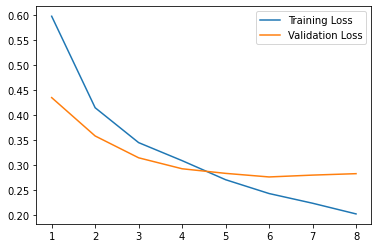

In [30]:
tr_loss_list
val_loss_list
x= range(1,epochs+1)
plt.plot(x, tr_loss_list, label = "Training Loss")
plt.plot(x, val_loss_list, label = "Validation Loss")
plt.legend()
plt.show()

0.8956 
4000 datapoints 


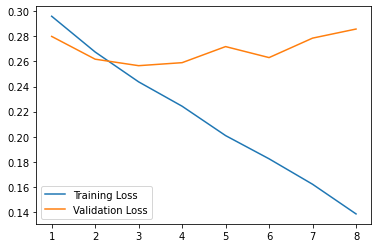

In [43]:
tr_loss_list
val_loss_list
x= range(1,epochs+1)
plt.plot(x, tr_loss_list, label = "Training Loss")
plt.plot(x, val_loss_list, label = "Validation Loss")
plt.legend()
plt.show()

results for 10000 datapoints 
0.8974

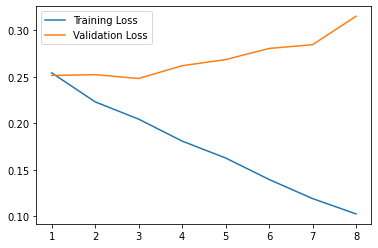

In [71]:
tr_loss_list
val_loss_list
x= range(1,epochs+1)
plt.plot(x, tr_loss_list, label = "Training Loss")
plt.plot(x, val_loss_list, label = "Validation Loss")
plt.legend()
plt.show()

results for 15000 datapoints 
0.8947

# Final Experimentation
40000 distributed according to the actual imbalancy in the dataset 

In [74]:
df_new_1 = df_new_1.sample(frac=0.031)

In [75]:
df_new_00_1 = df_new_0.sample(frac = 0.031)

In [76]:
df_1= pd.concat([df_new_1, df_new_00_1], ignore_index= True)

In [77]:
df_1['target'].value_counts()

0    37985
1     2505
Name: target, dtype: int64

In [85]:
# Repeating the steps in the above models to create an attention mask and embedding layer to compute further results 
device = trh.device('cuda' if trh.cuda.is_available() else 'cpu')

epochs = 8

tr_loss_list= []
val_loss_list= []

for _ in tqdm.trange(epochs, desc = 'Epoch'):
    
    # ========== Training ==========
    
    
    bert_Model.train()
    
    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    
    for step, batch in enumerate(training_data_l):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()
        # Forward pass
        train_output = bert_Model(b_input_ids, 
                             token_type_ids = None, 
                             attention_mask = b_input_mask, 
                             labels = b_labels)
        
        # Backward pass
        train_output.loss.backward()
        optimizer.step()

        # Update tracking variables
        tr_loss += train_output.loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    # ========== Validation ==========

    # Set model to evaluation mode
    bert_Model.eval()
    
    # Tracking variables 
    predictions= []
    true_labels= []
    
    val_accuracy = []
    val_precision = []
    val_recall = []
    val_specificity = []

    val_loss= 0

    for batch in validation_data_l:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with trh.no_grad():
          # Forward pass
          eval_output = bert_Model(b_input_ids, 
                              token_type_ids = None, 
                              attention_mask = b_input_mask,
                              labels= b_labels.long())
        
        logits = eval_output.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        #Calculate validation metrics
        b_accuracy, b_precision, b_recall, b_specificity = b_metrics(logits, label_ids)
        val_accuracy.append(b_accuracy)
        
        val_loss += eval_output.loss.item()

        predictions.extend(np.argmax(logits,axis=1).flatten())
        true_labels.extend(label_ids.flatten())

        # Update precision only when (tp + fp) !=0; ignore nan
        if b_precision != 'nan': val_precision.append(b_precision)
        # Update recall only when (tp + fn) !=0; ignore nan
        if b_recall != 'nan': val_recall.append(b_recall)
        # Update specificity only when (tn + fp) !=0; ignore nan
        if b_specificity != 'nan': val_specificity.append(b_specificity)
    
    macro_f1= f1_score(predictions,true_labels,average='macro')
    #if macro_f1 > best_macro_f1:
     #   best_macro_f1 = macro_f1
      #  trh.save(mBert,'/content/drive/MyDrive/MScProject/model_hindi_task_a_2_mBert.pt')
    
    tr_loss_list.append(tr_loss/nb_tr_steps)
    val_loss_list.append(val_loss/len(validation_data_l))
    print('\n\t - f1_score: {:.4f}'.format(macro_f1))
    print('\t - Train loss: {:.4f}'.format(tr_loss/nb_tr_steps))
    print('\t - Valid loss: {:.4f}'.format(val_loss/len(validation_data_l)))
    print('\t - Validation Accuracy: {:.4f}'.format(sum(val_accuracy)/len(val_accuracy)))
    print('\t - Validation Precision: {:.4f}'.format(sum(val_precision)/len(val_precision)) if len(val_precision)>0 else '\t - Validation Precision: NaN')
    print('\t - Validation Recall: {:.4f}'.format(sum(val_recall)/len(val_recall)) if len(val_recall)>0 else '\t - Validation Recall: NaN')
    print('\t - Validation Specificity: {:.4f}\n'.format(sum(val_specificity)/len(val_specificity)) if len(val_specificity)>0 else '\t - Validation Specificity: NaN')


Epoch:  12%|█▎        | 1/8 [14:08<1:38:57, 848.19s/it]


	 - f1_score: 0.8137
	 - Train loss: 0.1123
	 - Valid loss: 0.1008
	 - Validation Accuracy: 0.9604
	 - Validation Precision: 0.7073
	 - Validation Recall: 0.5948
	 - Validation Specificity: 0.9847



Epoch:  25%|██▌       | 2/8 [28:16<1:24:49, 848.17s/it]


	 - f1_score: 0.8109
	 - Train loss: 0.0945
	 - Valid loss: 0.0998
	 - Validation Accuracy: 0.9613
	 - Validation Precision: 0.7456
	 - Validation Recall: 0.5661
	 - Validation Specificity: 0.9875



Epoch:  38%|███▊      | 3/8 [42:24<1:10:41, 848.23s/it]


	 - f1_score: 0.8145
	 - Train loss: 0.0849
	 - Valid loss: 0.1067
	 - Validation Accuracy: 0.9614
	 - Validation Precision: 0.7356
	 - Validation Recall: 0.5815
	 - Validation Specificity: 0.9866



Epoch:  50%|█████     | 4/8 [56:32<56:32, 848.20s/it]  


	 - f1_score: 0.8192
	 - Train loss: 0.0713
	 - Valid loss: 0.1072
	 - Validation Accuracy: 0.9583
	 - Validation Precision: 0.6645
	 - Validation Recall: 0.6636
	 - Validation Specificity: 0.9781



Epoch:  62%|██████▎   | 5/8 [1:10:40<42:24, 848.14s/it]


	 - f1_score: 0.8233
	 - Train loss: 0.0569
	 - Valid loss: 0.1216
	 - Validation Accuracy: 0.9597
	 - Validation Precision: 0.6763
	 - Validation Recall: 0.6586
	 - Validation Specificity: 0.9796



Epoch:  75%|███████▌  | 6/8 [1:24:48<28:16, 848.06s/it]


	 - f1_score: 0.8162
	 - Train loss: 0.0458
	 - Valid loss: 0.1314
	 - Validation Accuracy: 0.9592
	 - Validation Precision: 0.6792
	 - Validation Recall: 0.6291
	 - Validation Specificity: 0.9812



Epoch:  88%|████████▊ | 7/8 [1:38:56<14:07, 847.86s/it]


	 - f1_score: 0.8070
	 - Train loss: 0.0362
	 - Valid loss: 0.1515
	 - Validation Accuracy: 0.9566
	 - Validation Precision: 0.6586
	 - Validation Recall: 0.6209
	 - Validation Specificity: 0.9789



Epoch: 100%|██████████| 8/8 [1:53:03<00:00, 847.94s/it]


	 - f1_score: 0.8082
	 - Train loss: 0.0302
	 - Valid loss: 0.1521
	 - Validation Accuracy: 0.9540
	 - Validation Precision: 0.6103
	 - Validation Recall: 0.6735
	 - Validation Specificity: 0.9730



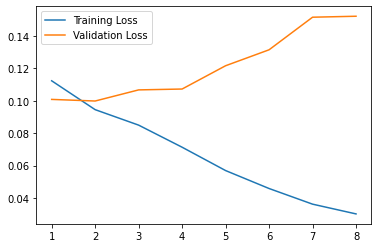

In [86]:
# Final Experiment plot 
tr_loss_list
val_loss_list
x= range(1,epochs+1)
plt.plot(x, tr_loss_list, label = "Training Loss")
plt.plot(x, val_loss_list, label = "Validation Loss")
plt.legend()
plt.show()